# 目录
+ 线性回归模型  
++  拟合  
++  预测  
+ 衡量线性回归模型  
-- 画残差图  
-- 离差之和接近于0  
-- 画残差Q-Q图  
-- 计算MSE,MAD  
-- 做【boostrap】寻找系数的分布  
+ 岭回归  
+ 最优化岭回归的参数  
-- 交叉验证选择惩罚系数  
-- 画交叉验证图
+ LASSO回归  
--lasso做特征选择  
+ 最小角回归 Least-angle regression (LARS)  
-- 适用于p>>n  
+ Logistic回归  
-- 考虑类别不平衡问题    
+ 贝叶斯岭回归  
+ 梯度提升回归  

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from pandas import Series,DataFrame
import pandas as pd
import seaborn as sns

In [2]:
%matplotlib inline

## Linear regression  
 LinearRegression类
 - 拟合
 - 预测

In [3]:
from sklearn.linear_model import LinearRegression

In [4]:
# 准备数据
from sklearn import datasets
boston = datasets.load_boston()

In [5]:
lr = LinearRegression()
lr.fit(boston.data, boston.target)   # 模型拟合
predictions = lr.predict(boston.data)   # 求解拟合值

In [6]:
lr.coef_   # 查看系数

array([ -1.07170557e-01,   4.63952195e-02,   2.08602395e-02,
         2.68856140e+00,  -1.77957587e+01,   3.80475246e+00,
         7.51061703e-04,  -1.47575880e+00,   3.05655038e-01,
        -1.23293463e-02,  -9.53463555e-01,   9.39251272e-03,
        -5.25466633e-01])

In [7]:
# 展示特征名和系数估计值
zip(boston.feature_names, lr.coef_)

[('CRIM', -0.10717055656035689),
 ('ZN', 0.046395219529797617),
 ('INDUS', 0.020860239532173769),
 ('CHAS', 2.6885613993179573),
 ('NOX', -17.795758660309158),
 ('RM', 3.8047524602580145),
 ('AGE', 0.00075106170332382217),
 ('DIS', -1.4757587965198196),
 ('RAD', 0.30565503833910118),
 ('TAX', -0.012329346305270586),
 ('PTRATIO', -0.95346355469055821),
 ('B', 0.0093925127221889965),
 ('LSTAT', -0.52546663290078111)]

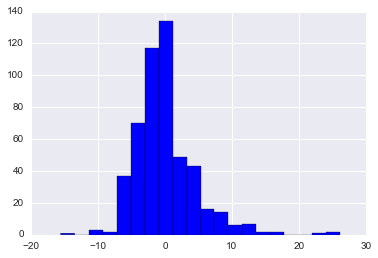

In [8]:
# 查看残差图
residual =  boston.target - predictions  
plt.hist(residual,bins = 20,color = "blue")
plt.show()

In [9]:
lr = LinearRegression()   # 查看默认设置
lr

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [10]:
lr2 = LinearRegression(normalize=True)   # 修改默认设置,特征标准化处理
lr2.fit(boston.data, boston.target)
LinearRegression(copy_X=True, fit_intercept=True, normalize=True)
predictions2 = lr2.predict(boston.data)

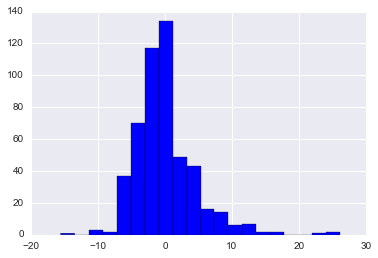

In [11]:
residual = boston.target - predictions2 
plt.hist(residual,bins = 20,color = "blue")
plt.show()

## 评估回归模型
- 画残差图
- 离差之和接近于0
- 画残差Q-Q图
- 计算MSE,MAD
- 做【boostrap】寻找系数的分布

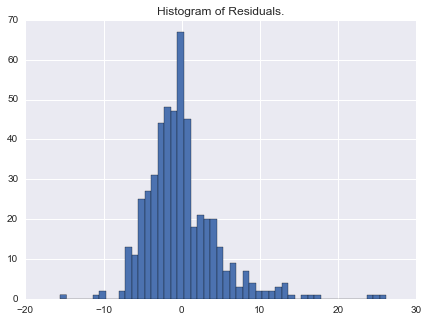

In [12]:
# 画残差图

f = plt.figure(figsize=(7, 5))
ax = f.add_subplot(111)
ax.hist(boston.target - predictions, bins=50)   # 右偏
ax.set_title("Histogram of Residuals.")

In [13]:
#  离差之和接近于0 

np.mean(boston.target - predictions)

1.0447505838053647e-14

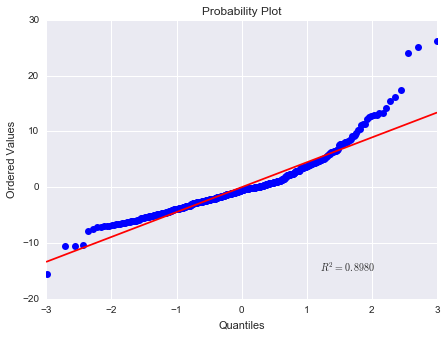

In [14]:
#  残差Q-Q图检验残差的分布

from scipy.stats import probplot

f = plt.figure(figsize=(7, 5))
ax = f.add_subplot(111)
probplot(boston.target - predictions, plot=ax);   # 右偏

In [15]:
# 计算MSE

def MSE(target, predictions):
    squared_deviation = np.power(target - predictions, 2)
    return np.mean(squared_deviation)
MSE(boston.target, predictions)

21.897779217687496

In [16]:
# 计算MAD

def MAD(target, predictions):
    absolute_deviation = np.abs(target - predictions)
    return np.mean(absolute_deviation)
MAD(boston.target, predictions)

3.2729446379969342

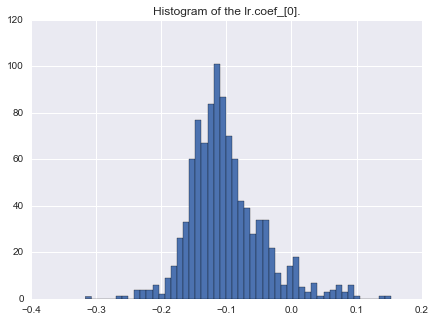

In [17]:
# 做boostrap证明系数稳健

n_bootstraps = 1000
len_boston = len(boston.target)
subsample_size = np.int(0.5*len_boston)  # 新样本数为原始样本的一半
subsample = lambda: np.random.choice(np.arange(0, len_boston),size=subsample_size)   # 抽取新样本
coefs = np.ones(n_bootstraps) #创建一个1000维的序列以便存放系数


for i in range(n_bootstraps):           # 得到1000次重复的系数
    subsample_idx = subsample()   # 调用函数抽取样本
    subsample_X = boston.data[subsample_idx]
    subsample_y = boston.target[subsample_idx]
    lr.fit(subsample_X, subsample_y)
    coefs[i] = lr.coef_[0]
    
    
import matplotlib.pyplot as plt
f = plt.figure(figsize=(7, 5))
ax = f.add_subplot(111)
ax.hist(coefs, bins=50)
ax.set_title("Histogram of the lr.coef_[0].")   # 做1000次的系数的分布图

In [18]:
np.percentile(coefs, [2.5, 97.5])     # 求1000个系数的置信区间

array([-0.19061006,  0.04076908])

## 岭回归
*‘平方的惩罚’

In [19]:
from sklearn.linear_model import Ridge

In [20]:
# 准备不满秩数据
from sklearn.datasets import make_regression
reg_data, reg_target = make_regression(n_samples=2000,n_features=3, effective_rank=2, noise=10)  # 2000*3，但是有一个特征无效

使用岭回归

In [21]:
r = Ridge()
r       # 可以查看默认设置

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [22]:
# 通过boostrap求解1000次岭回归的系数

n_bootstraps = 1000
len_data = len(reg_data)
subsample_size = np.int(0.75*len_data)
subsample = lambda: np.random.choice(np.arange(0, len_data),size=subsample_size)
coefs_r = np.ones((n_bootstraps, 3))

for i in range(n_bootstraps):
    subsample_idx = subsample()
    subsample_X = reg_data[subsample_idx]
    subsample_y = reg_target[subsample_idx]
    r.fit(subsample_X, subsample_y)
    coefs_r[i][0] = r.coef_[0]
    coefs_r[i][1] = r.coef_[1]
    coefs_r[i][2] = r.coef_[2]

In [23]:
r.predict(reg_data)   # 可以做预测

array([ 0.6147283 ,  0.09345224, -0.62653165, ...,  0.67667111,
        1.11257285, -0.01581259])

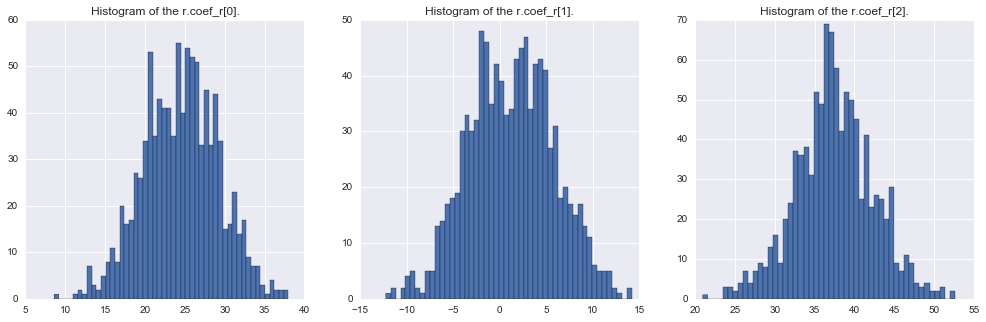

In [24]:
# 做1000次的岭回归系数的分布图

import matplotlib.pyplot as plt
f = plt.figure(figsize=(17, 5))
ax1 = f.add_subplot(131)
ax1.hist(coefs_r[:,0], bins=50)
ax1.set_title("Histogram of the r.coef_r[0].")   
ax2 = f.add_subplot(132)
ax2.hist(coefs_r[:,1], bins=50)
ax2.set_title("Histogram of the r.coef_r[1].")
ax3 = f.add_subplot(133)
ax3.hist(coefs_r[:,2], bins=50)
ax3.set_title("Histogram of the r.coef_r[2].")

使用普通线性回归

In [25]:
# 通过boostrap求解1000次普通线性回归的系数

n_bootstraps = 1000
len_data = len(reg_data)
subsample_size = np.int(0.75*len_data)
subsample = lambda: np.random.choice(np.arange(0, len_data),size=subsample_size)
coefs = np.ones((n_bootstraps, 3))

for i in range(n_bootstraps):
    subsample_idx = subsample()
    subsample_X = reg_data[subsample_idx]
    subsample_y = reg_target[subsample_idx]
    lr.fit(subsample_X, subsample_y)
    coefs[i][0] = lr.coef_[0]
    coefs[i][1] = lr.coef_[1]
    coefs[i][2] = lr.coef_[2]

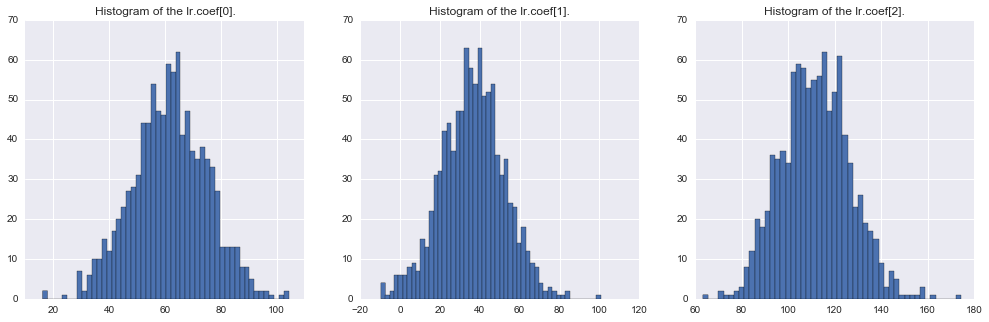

In [26]:
# 做1000次的普通线性回归系数的分布图

import matplotlib.pyplot as plt
f = plt.figure(figsize=(17, 5))
ax1 = f.add_subplot(131)
ax1.hist(coefs[:,0], bins=50)
ax1.set_title("Histogram of the lr.coef[0].")   
ax2 = f.add_subplot(132)
ax2.hist(coefs[:,1], bins=50)
ax2.set_title("Histogram of the lr.coef[1].")
ax3 = f.add_subplot(133)
ax3.hist(coefs[:,2], bins=50)
ax3.set_title("Histogram of the lr.coef[2].")

两个回归方法结果的比较  
    - 从图形上看，没什么太大的差别  
    - 比较系数的大小  
    - 比较系数的方差  

In [27]:
np.mean(coefs - coefs_r, axis=0)   # 线性回归的系数比较大

array([ 37.24236542,  35.24406694,  74.41015245])

In [28]:
np.var(coefs, axis=0),np.var(coefs_r, axis=0)   # 线性回归系数的方差远大于岭回归

(array([ 180.76020532,  250.24540406,  218.97804929]),
 array([ 22.17003783,  20.90879927,  23.7222016 ]))

## 最优化岭回归的参数---惩罚系数的选择

In [29]:
from sklearn.linear_model import RidgeCV

In [30]:
# 准备数据
from sklearn.datasets import make_regression
reg_data, reg_target = make_regression(n_samples=100,n_features=2, effective_rank=1, noise=10)

#### 岭回归选择alpha的过程

In [31]:
rcv = RidgeCV()   # 查看默认设置
rcv

RidgeCV(alphas=(0.1, 1.0, 10.0), cv=None, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)

In [32]:
rcv = RidgeCV(alphas=np.array([.1, .2, .3, .4]))   # 修改alpha参数
rcv.fit(reg_data, reg_target)

RidgeCV(alphas=array([ 0.1,  0.2,  0.3,  0.4]), cv=None, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [33]:
rcv.alpha_     # 自动给出在岭回归过程中，以上参数中最优的参数，在0.1周围

0.10000000000000001

In [34]:
# 继续在0.1附近选择更加精确的alpha值

rcv2 = RidgeCV(alphas=np.array([.08, .09, .1, .11, .12]))
rcv2.fit(reg_data, reg_target)
rcv2.alpha_  


# 这个过程可以一步一步的细化。。。。

0.080000000000000002

#### 绘制交叉验证的图

In [35]:
alphas_to_test = np.linspace(0.01, 1)   # 从0.01到1之间取50个数
rcv3 = RidgeCV(alphas=alphas_to_test, store_cv_values=True)  # 修改alpha值，并且存储cv值
rcv3.fit(reg_data, reg_target)

RidgeCV(alphas=array([ 0.01   ,  0.0302 ,  0.05041,  0.07061,  0.09082,  0.11102,
        0.13122,  0.15143,  0.17163,  0.19184,  0.21204,  0.23224,
        0.25245,  0.27265,  0.29286,  0.31306,  0.33327,  0.35347,
        0.37367,  0.39388,  0.41408,  0.43429,  0.45449,  0.47469,
        0.4949 ,  0.5151 ...3837,
        0.85857,  0.87878,  0.89898,  0.91918,  0.93939,  0.95959,
        0.9798 ,  1.     ]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=True)

In [36]:
rcv3.cv_values_.shape   # 每做一个交叉验证，都尝试50个alpha值，就由100次*50个这么多个的误差值

(100L, 50L)

In [37]:
smallest_idx = rcv3.cv_values_.mean(axis=0).argmin()    # 每一列求和，寻找最小的误差均值
alphas_to_test[smallest_idx]    # 找出对应的alpha

0.030204081632653063

In [38]:
rcv3.alpha_     # 与真正系统决定的alpha一致哦

0.030204081632653063

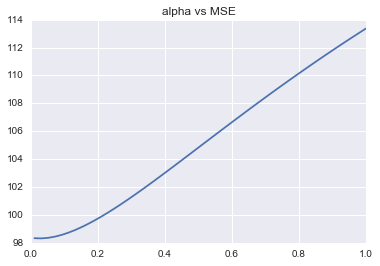

In [39]:
plt.plot(alphas_to_test,rcv3.cv_values_.mean(axis=0))
plt.title( 'alpha vs MSE')
plt.show()

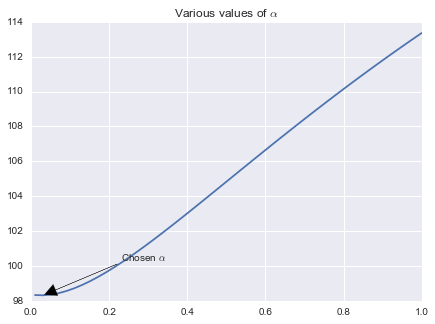

In [40]:
f, ax = plt.subplots(figsize=(7, 5))
ax.set_title(r"Various values of $\alpha$")

xy = (alphas_to_test[smallest_idx], rcv3.cv_values_.mean(axis=0)[smallest_idx])
xytext = (xy[0] + .2, xy[1] + 2)

ax.annotate(r'Chosen $\alpha$', xy=xy, xytext=xytext,
            arrowprops=dict(facecolor='black', shrink=0.02, width=.02)
            )

ax.plot(alphas_to_test, rcv3.cv_values_.mean(axis=0));

#### 　定义最优化目标函数 (loss function)

In [41]:
def MAD(target, predictions):
    absolute_deviation = np.abs(target - predictions)
    return absolute_deviation.mean()

In [42]:
import sklearn

MAD = sklearn.metrics.make_scorer(MAD, greater_is_better=False)   # 设置MAD为损失函数，且越小越好

rcv4 = RidgeCV(alphas=alphas_to_test, store_cv_values=True,scoring=MAD)
rcv4.fit(reg_data, reg_target)

smallest_idx = rcv4.cv_values_.mean(axis=0).argmin()   # 寻找使损失函数最小的alpha值
alphas_to_test[smallest_idx]

0.01

In [43]:
rcv4.alpha_   

0.030204081632653063

## LASSO回归
*“绝对值的 ”惩罚

In [44]:
from sklearn.linear_model import Lasso

In [45]:
# 创建不满秩数据集
from sklearn.datasets import make_regression
reg_data, reg_target = make_regression(n_samples=200, n_features=500,n_informative=5, noise=5)

In [46]:
lasso = Lasso()

In [47]:
lasso.fit(reg_data, reg_target)   # 默认惩罚为1

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [48]:
np.sum(lasso.coef_ != 0)  # 不为0的系数个数

9

In [49]:
lasso_0 = Lasso(0)   #修改惩罚为0，相当于普通线性回归
lasso_0.fit(reg_data, reg_target)
np.sum(lasso_0.coef_ != 0)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  from ipykernel import kernelapp as app
C:\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:465: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)


500

#### 最优化lasso回归的参数---交叉验证选择alpha
LassoCV类

In [50]:
from sklearn.linear_model import LassoCV

In [51]:
lassocv = LassoCV()
lassocv.fit(reg_data, reg_target)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [52]:
lassocv.alpha_   # 输出最优的alpha

0.7213939536930819

In [53]:
lassocv.coef_[:5]   # 输出回归系数

array([ 93.60693448,  -0.        ,   0.        ,   0.        ,  -0.        ])

In [54]:
np.sum(lassocv.coef_ != 0)   # 统计系数不为0的特征的个数

20

#### 利用lasso做特征选择

In [55]:
mask = lassocv.coef_ != 0
new_reg_data = reg_data[:, mask]  # 取出系数不为0的特征
new_reg_data.shape

(200L, 20L)

## Least-angle regression (LARS)回归
适用于高维问题 p>>n

In [56]:
from sklearn.linear_model import Lars

In [57]:
# 生成高维数据
from sklearn.datasets import make_regression
reg_data, reg_target = make_regression(n_samples=200,n_features=500, n_informative=10, noise=2)

In [58]:
lars = Lars(n_nonzero_coefs=10)   # 制定选择10维特征
lars.fit(reg_data, reg_target)

Lars(copy_X=True, eps=2.2204460492503131e-16, fit_intercept=True,
   fit_path=True, n_nonzero_coefs=10, normalize=True, positive=False,
   precompute='auto', verbose=False)

In [59]:
np.sum(lars.coef_ != 0)   #验证真的仅有10维特征被留下，其余的系数均为0

10

#### 使用lars的意义

In [60]:
train_n = 100

lars_12 = Lars(n_nonzero_coefs=12)   # 指定选择12维特征
lars_12.fit(reg_data[:train_n], reg_target[:train_n])

lars_500 = Lars() # 不指定特征数，即默认为不筛选，仍为500维
lars_500.fit(reg_data[:train_n], reg_target[:train_n]);

C:\Anaconda2\lib\site-packages\sklearn\linear_model\least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 125 iterations, i.e. alpha=3.323e-02, with an active set of 101 regressors, and the smallest cholesky pivot element being 5.960e-08
  ConvergenceWarning)
C:\Anaconda2\lib\site-packages\sklearn\linear_model\least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 125 iterations, i.e. alpha=3.313e-02, with an active set of 101 regressors, and the smallest cholesky pivot element being 7.743e-08
  ConvergenceWarning)
C:\Anaconda2\lib\site-packages\sklearn\linear_model\least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 125 iterations, i.e. alpha=3.282e-02, with an active set of 101 regressors, and the smallest cholesky pivot element being 6.322e-08
  ConvergenceWarning)
C:\Anaconda2\lib\site-packages\sklearn\linear_model\least_angle.py:

In [61]:
np.mean(np.power(reg_target[train_n:] - lars_12.predict(reg_data[train_n:]), 2))  #计算MSE

10.086432165774582

In [62]:
np.mean(np.power(reg_target[train_n:] - lars_500.predict(reg_data[train_n:]), 2))  # 计算MSE，发现远大于进行选择的

1.3202708375787884e+35

#### 优化lars的参数-----通过交叉验证选择留下多少特征

In [63]:
from sklearn.linear_model import LarsCV

In [64]:
lcv = LarsCV()
lcv.fit(reg_data, reg_target)

C:\Anaconda2\lib\site-packages\sklearn\linear_model\least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 172 iterations, i.e. alpha=2.823e-02, with an active set of 133 regressors, and the smallest cholesky pivot element being 5.960e-08
  ConvergenceWarning)
C:\Anaconda2\lib\site-packages\sklearn\linear_model\least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 172 iterations, i.e. alpha=2.692e-02, with an active set of 133 regressors, and the smallest cholesky pivot element being 3.942e-08
  ConvergenceWarning)
C:\Anaconda2\lib\site-packages\sklearn\linear_model\least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 172 iterations, i.e. alpha=2.487e-02, with an active set of 133 regressors, and the smallest cholesky pivot element being 5.162e-08
  ConvergenceWarning)
C:\Anaconda2\lib\site-packages\sklearn\linear_model\least_angle.py:

LarsCV(copy_X=True, cv=None, eps=2.2204460492503131e-16, fit_intercept=True,
    max_iter=500, max_n_alphas=1000, n_jobs=1, normalize=True,
    positive=False, precompute='auto', verbose=False)

In [65]:
np.sum(lcv.coef_ != 0)   # 返回选择留下的特征个数

20

#### lars工作原理  
1.对Predictors进行标准化（去除不同尺度的影响），对Target Variable进行中心化（去除截距项的影响），初始的所有系数都设为0，此时残差 r 就等于中心化后的Target Variable  
2.找出和残差r相关度最高的变量X_j    
3.将X_j的系数Beta_j 从0开始沿着LSE（只有一个变量X_j的最小二乘估计）的方向变化，直到某个新的变量X_k与残差r的相关性大于X_j时  
4.X_j和X_k的系数Beta_j和Beta_k，一起沿着新的LSE（加入了新变量X_k的最小二乘估计）的方向移动，直到有新的变量被选入  
5.重复2，3，4，直到所有变量被选入，最后得到的估计就是普通线性回归的OLS  

##  逻辑回归

In [66]:
from sklearn.linear_model import LogisticRegression

In [67]:
# 准备1个分类数据集
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=4)

X_train = X[:-200]   #将数据分为训练集和测试集
X_test = X[-200:]
y_train = y[:-200]
y_test = y[-200:]

In [68]:
lr = LogisticRegression()

In [69]:
lr.fit(X_train, y_train)
y_train_predictions = lr.predict(X_train)  # 在训练集上做预测
y_test_predictions = lr.predict(X_test)    # 在测试集上做预测

In [70]:
(y_train_predictions == y_train).sum().astype(float) /y_train.shape[0] # 在训练集集上的预测准确率

0.85875000000000001

In [71]:
(y_test_predictions == y_test).sum().astype(float) /y_test.shape[0]   # 在测试集上的预测准确率

0.88

#### 类别不平衡问题

In [72]:
# 准备一个类别不平衡的数据集
X, y = make_classification(n_samples=5000, n_features=4,weights=[.95])

X_train = X[:-500]   # 取后500个样本为测试集
X_test = X[-500:]
y_train = y[:-500]
y_test = y[-500:]

In [73]:
sum(y) / (len(y)*1.)  # 确保正例仅占5%

0.055

按正常逻辑回归的方法做

In [74]:
lr.fit(X_train, y_train)
y_train_predictions = lr.predict(X_train)
y_test_predictions = lr.predict(X_test)

In [75]:
(y_train_predictions == y_train).sum().astype(float) /y_train.shape[0]   # 准确率都很高，但是即使全部判别为0也有95%的准确率

0.94088888888888889

In [76]:
(y_test_predictions == y_test).sum().astype(float) / y_test.shape[0]

0.94599999999999995

In [77]:
(y_test[y_test==1] == y_test_predictions[y_test==1]).sum().astype(float) / y_test[y_test==1].shape[0]  # 类别1的准确率不高

0.16666666666666666

考虑类别不平衡的现象

In [78]:
lr = LogisticRegression(class_weight={0: .15, 1: .85})    # 0类比例为0.05，设置0:0.15，对0类过采样

In [79]:
lr.fit(X_train, y_train)
y_train_predictions = lr.predict(X_train)
y_test_predictions = lr.predict(X_test)

In [80]:
(y_test[y_test==1] == y_test_predictions[y_test==1]).sum().astype(float) / y_test[y_test==1].shape[0]   # 类别1的正确率大大提高

0.66666666666666663

In [81]:
(y_test_predictions == y_test).sum().astype(float) / y_test.shape[0]   #整体准确率稍有下降

0.91400000000000003

## 贝叶斯岭回归

In [82]:
from sklearn.linear_model import BayesianRidge

In [83]:
# 准备不满秩数据
from sklearn.datasets import make_regression
X, y = make_regression(1000, 10, n_informative=2, noise=20)

In [84]:
br = BayesianRidge()  # 通常要修改的参数为alpha_1，alpha_2，lambda_1，lambda_2

In [85]:
br.fit(X, y)
br.coef_

array([  6.31964566e+01,   7.82393743e-02,   7.09571051e-01,
        -9.71124029e-01,  -3.51452164e-01,   5.52163571e-01,
         7.92502463e+01,   1.73406166e-01,  -4.40877680e-01,
        -1.10829707e+00])

In [86]:
br_alphas = BayesianRidge(alpha_1=10, lambda_1=10)   # 改变参数值，则系数发生变化，向0靠近，且越大的系数缩水越多
br_alphas.fit(X, y)
br_alphas.coef_

array([  6.31478692e+01,   7.76046980e-02,   7.08412860e-01,
        -9.70916429e-01,  -3.51476688e-01,   5.51067193e-01,
         7.91886973e+01,   1.67366883e-01,  -4.42860757e-01,
        -1.10597058e+00])

## Gradient boosting回归（梯度提升回归）

In [87]:
from sklearn.ensemble import GradientBoostingRegressor as GBR

In [88]:
# 准备数据
from sklearn.datasets import make_regression
X, y = make_regression(1000, 2, noise=10)

In [89]:
gbr = GBR()
gbr.fit(X, y)  # 拟合
gbr_preds = gbr.predict(X)  # 预测

In [90]:
# 与普通线性回归的结果作对比
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X, y)
lr_preds = lr.predict(X)  # 得到普通线性回归的预测值

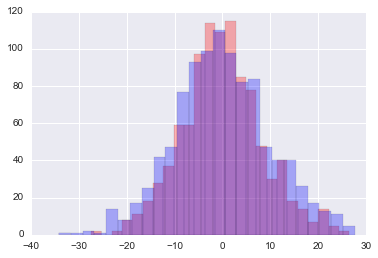

In [91]:
# 比较两者的残差

gbr_residuals = y - gbr_preds  #计算残差
lr_residuals = y - lr_preds

plt.hist(gbr_residuals,bins = 25,alpha = 0.3,label = 'gbr',color = 'red')
plt.hist(lr_residuals,bins = 25,alpha = 0.3,label = 'lr',color = 'b')
plt.show()

# 从图像上看，似乎梯度提升的残差要小一些，但是并不明显

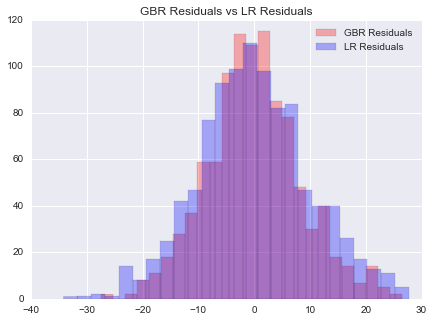

In [92]:
f, ax = plt.subplots(figsize=(7, 5))
ax.hist(gbr_residuals, bins=25, alpha=.3, label='GBR Residuals', color='r')
ax.hist(lr_residuals, bins=25, alpha=.3, label='LR Residuals', color='b')
ax.set_title("GBR Residuals vs LR Residuals")
ax.legend();

In [93]:
# 计算两者的置信区间

np.percentile(gbr_residuals, [2.5, 97.5]),np.percentile(lr_residuals, [2.5, 97.5])

#  前者明显要小一些，说明梯度提升效果更好

(array([-16.33383432,  18.43829919]), array([-20.09041554,  21.33159868]))

#### 关于梯度提升的参数

### max_depth
max_depth: Controls how many nodes are produced for the trees.  
### loss
loss: Determines the error.
+ 'ls': least squares regression.
+ 'lad': least absolute deviation. A highly robust loss function solely based on order information of the input variables.
+ 'huber': A combination of the two.
+ 'quantile': Allows quantile regression (use alpha to specify the quantile).




### n_estimators
n_estimators: The number of weak learners that are used in GBR.

In [94]:
n_estimators = np.arange(100, 1100, 350)
gbrs = [GBR(n_estimators=n_estimator) for n_estimator in n_estimators]

In [95]:
residuals = {}

for i, gbr in enumerate(gbrs):
    gbr.fit(X, y)
    residuals[gbr.n_estimators] = y - gbr.predict(X)

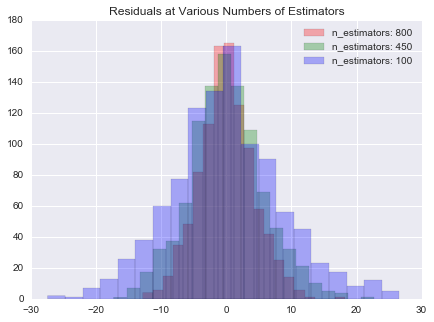

In [96]:
f, ax = plt.subplots(figsize=(7, 5))
colors = ['r', 'g', 'b']

for i, (k, v) in enumerate(residuals.iteritems()):
    ax.hist(v, bins=20, color=colors[i], alpha=.3, label='n_estimators: {}'.format(k))
    
ax.legend()
ax.set_title("Residuals at Various Numbers of Estimators");